In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
os.chdir('/content/drive/My Drive/assignment06')
!pwd

Mounted at /content/drive
/content/drive/My Drive/assignment06


In [3]:
import keras
import numpy as np
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
from keras import layers
tf.compat.v1.disable_eager_execution()
from keras.datasets import mnist
from tensorflow.keras.models import Model

from pathlib import Path

VAE encoder network

In [4]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 2

input_img = keras.Input(shape = img_shape)

x = layers.Conv2D(32, 3, padding = 'same', activation = 'relu')(input_img)
x = layers.Conv2D(64, 3, padding = 'same', activation = 'relu', strides = (2, 2))(x)
x = layers.Conv2D(64, 3, padding = 'same', activation = 'relu')(x)
x = layers.Conv2D(64, 3, padding = 'same', activation = 'relu')(x)

shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation = 'relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x) 

Latent-space-sampling function

In [5]:
def sampling(args):
  z_mean, z_log_var = args
  epsilon = K.random_normal(shape = (K.shape(z_mean)[0], latent_dim),
                            mean = 0., stddev = 1.)
  
  return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

VAE decoder network, mapping latent space points to images

In [6]:
decoder_input = layers.Input(K.int_shape(z)[1:])

x = layers.Dense(np.prod(shape_before_flattening[1:]), activation = 'relu')(decoder_input)
x = layers.Reshape(shape_before_flattening[1:])(x)
x = layers.Conv2DTranspose(32, 3, padding = 'same', activation = 'relu', strides = (2, 2))(x)
x = layers.Conv2D(1, 3, padding = 'same', activation = 'sigmoid')(x)

decoder = Model(decoder_input, x)
z_decoded = decoder(z)

Custom Layer used to computer the VAE loss

In [7]:
class customVariationalLayer(keras.layers.Layer):
  def vae_loss(self, x, z_decoded):
    x = K.flatten(x)
    z_decoded = K.flatten(z_decoded)

    xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
    
    kl_loss = -5e-4 * K.mean(
        1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis = -1
    )

    return K.mean(xent_loss + kl_loss)

  def call(self, inputs):
    x = inputs[0]
    z_decoded = inputs[1]

    loss = self.vae_loss(x, z_decoded)
    self.add_loss(loss, inputs = inputs)

    return x

In [8]:
y = customVariationalLayer()([input_img, z_decoded])

Training the VAE

In [9]:
vae = Model(input_img, y)
vae.compile(optimizer = 'rmsprop', loss = None)
vae.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 64)   36928       ['conv2d_1[0][0]']               
                                                                                            

In [10]:
(x_train, _), (x_test, y_test) = mnist.load_data()

In [11]:
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))

x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

In [12]:
vae.fit(x = x_train, y = None,
        shuffle = True,
        epochs = 10,
        batch_size = batch_size,
        validation_data = (x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - ETA: 0s - loss: 0.2151

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 250s 4ms/sample - loss: 0.2151 - val_loss: 0.1967
Epoch 2/10
60000/60000 [==============================] - 247s 4ms/sample - loss: 0.1935 - val_loss: 0.1922
Epoch 3/10
60000/60000 [==============================] - 246s 4ms/sample - loss: 0.1891 - val_loss: 0.1881
Epoch 4/10
60000/60000 [==============================] - 246s 4ms/sample - loss: 0.1866 - val_loss: 0.1856
Epoch 5/10
60000/60000 [==============================] - 245s 4ms/sample - loss: 0.1852 - val_loss: 0.1863
Epoch 6/10
60000/60000 [==============================] - 242s 4ms/sample - loss: 0.1840 - val_loss: 0.1837
Epoch 7/10
60000/60000 [==============================] - 244s 4ms/sample - loss: 0.1831 - val_loss: 0.1829
Epoch 8/10
60000/60000 [==============================] - 243s 4ms/sample - loss: 0.1823 - val_loss: 0.1844
Epoch 9/10
60000/60000 [==============================] - 243s 4ms/sample - loss: 0.1817 - val_loss: 0.1839
Epoch 10/10
60000/60000 [==============

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


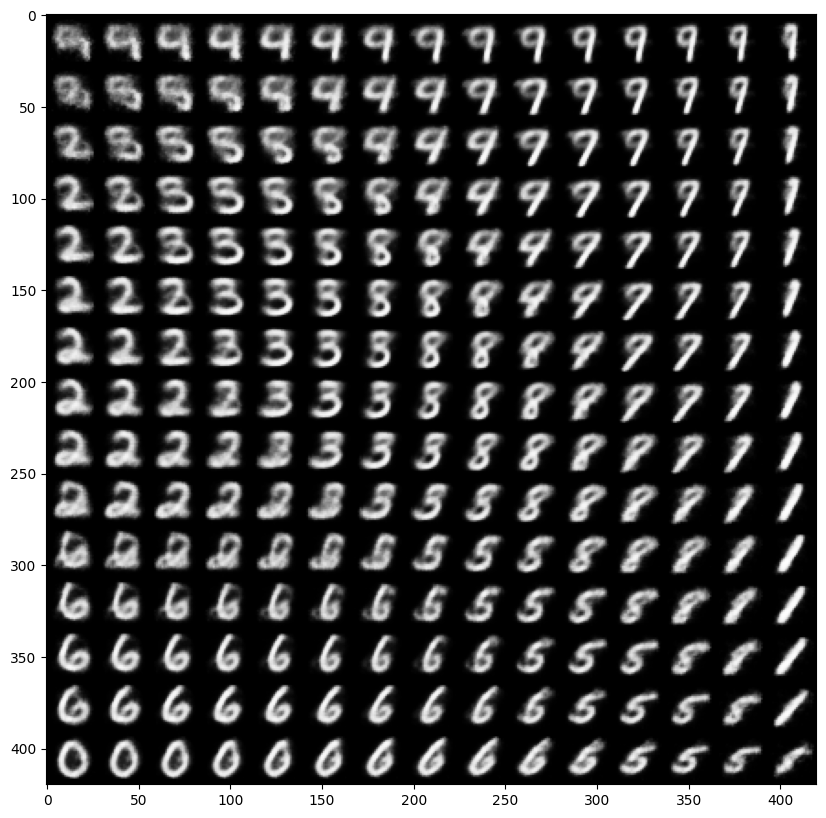

In [13]:
import matplotlib.pyplot as plt
from scipy.stats import norm

n = 15
digit_size = 28

figure = np.zeros((digit_size * n, digit_size * n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
  for j, xi in enumerate(grid_y):
    z_sample = np.array([[xi, yi]])
    z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)

    x_decoded = decoder.predict(z_sample, batch_size = batch_size)

    digit = x_decoded[0].reshape(digit_size, digit_size)

    figure[i * digit_size: (i + 1) * digit_size,
           j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize = (10, 10))
plt.imshow(figure, cmap = 'Greys_r')

# Save figure
plt.savefig('results/vae.png',
           bbox_inches = 'tight',
           transparent = True)

plt.show()